
Audio Feature Extraction and Transformer Model for Audio Classification

This code implements a deep learning model for audio classification using a transformer architecture.
The pipeline includes audio feature extraction (mel spectrogram and MFCC), 
positional encoding, and a transformer-based classifier.

Key components:
1. Audio feature extraction with librosa
2. Transformer model with positional encoding
3. Custom dataset handling
4. Training loop with monitoring and early stopping


In [19]:
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
# Cell 2 - Check GPU availability and display device information
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU Device Name: {torch.cuda.get_device_name(0)}')
    print(f'Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU Device Name: NVIDIA GeForce RTX 3060 Laptop GPU
Available GPU Memory: 6.00 GB



Audio Feature Extraction Module

This module provides functionality for extracting and processing audio features.
Key features include:
- Loading audio files using librosa
- Extracting mel spectrogram and MFCC features
- Standardizing feature sequence lengths
- Real-time processing information output


In [21]:

def load_audio_features(file_path, fixed_length=130):
    """Extract mel spectrogram and MFCC features from audio file with length standardization"""
    try:
        # Load and display basic audio information
        y, sr = librosa.load(file_path)
        print(f"\nAudio file loaded: {file_path}")
        print(f"Sample rate: {sr} Hz")
        print(f"Duration: {len(y)/sr:.2f} seconds")
        
        # Convert audio to mel spectrogram representation
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        print(f"Mel spectrogram shape: {mel_spec_db.shape}")
        
        # Extract MFCC features for additional audio characteristics
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        print(f"MFCC features shape: {mfccs.shape}")
        
        def pad_or_truncate(array, target_length):
            """Standardize array length by either truncating or zero-padding"""
            current_length = array.shape[1]
            if current_length > target_length:
                print(f"Truncating from {current_length} to {target_length}")
                return array[:, :target_length]
            else:
                print(f"Padding from {current_length} to {target_length}")
                pad_width = ((0, 0), (0, target_length - current_length))
                return np.pad(array, pad_width, mode='constant')
        
        # Ensure consistent feature lengths for model input
        mel_spec_db = pad_or_truncate(mel_spec_db, fixed_length)
        mfccs = pad_or_truncate(mfccs, fixed_length)
        
        # Return processed features as float32 arrays
        return {
            'mel_spec': mel_spec_db.astype(np.float32),
            'mfcc': mfccs.astype(np.float32)
        }
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None


Positional Encoding Module

This module implements the positional encoding mechanism for transformer models.
It adds position information to input embeddings using sine and cosine functions
of different frequencies, allowing the model to learn sequence order.


In [22]:

class PositionalEncoding(nn.Module):
    """
    Positional encoding layer that adds position information to input embeddings.
    Uses sinusoidal functions to create unique position embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        """
        Initialize positional encoding layer.
        
        Args:
            d_model: Dimension of the model embeddings
            max_len: Maximum sequence length to pre-compute encodings for
        """
        super().__init__()
        print(f"\nInitializing Positional Encoding:")
        print(f"Model dimension: {d_model}")
        print(f"Maximum sequence length: {max_len}")
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        # Create position indices tensor [[0], [1], [2], ...]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Calculate division terms for different frequencies
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # Add batch dimension [1, max_len, d_model]
        pe = pe.unsqueeze(0)
        
        # Register buffer (persistent state that's not considered model parameters)
        self.register_buffer('pe', pe)
        
        print(f"Positional encoding tensor shape: {pe.shape}")

    def forward(self, x):
        """
        Add positional encoding to input tensor.
        
        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model]
            
        Returns:
            Input tensor with positional encoding added
        """
        return x + self.pe[:, :x.size(1)]


Audio Transformer Model

This model implements a transformer-based architecture for audio classification.
It processes mel spectrogram and MFCC features through a transformer encoder
and outputs binary classification predictions.

Architecture:
1. Feature embedding layers for mel spectrogram and MFCC
2. Positional encoding
3. Transformer encoder
4. Classification head with dropout layers


In [23]:

class AudioTransformer(nn.Module):
    """
    Transformer model for processing and classifying audio features
    """
    def __init__(self, mel_channels=128, mfcc_channels=20, d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1):
        """
        Initialize the Audio Transformer model.
        
        Args:
            mel_channels: Number of mel spectrogram frequency bands
            mfcc_channels: Number of MFCC coefficients
            d_model: Dimension of model embeddings
            nhead: Number of attention heads
            num_layers: Number of transformer encoder layers
            dim_feedforward: Dimension of feedforward network
            dropout: Dropout rate
        """
        super().__init__()
        # Print model configuration
        print("\nInitializing Audio Transformer Model:")
        print(f"Mel channels: {mel_channels}")
        print(f"MFCC channels: {mfcc_channels}")
        print(f"Model dimension: {d_model}")
        print(f"Number of attention heads: {nhead}")
        print(f"Number of transformer layers: {num_layers}")
        print(f"Feedforward dimension: {dim_feedforward}")
        print(f"Dropout rate: {dropout}")
        
        # Feature embedding layers
        self.mel_embed = nn.Linear(mel_channels, d_model)
        self.mfcc_embed = nn.Linear(mfcc_channels, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder configuration
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification network
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, mel_spec, mfcc):
        """
        Process audio features through the model.
        
        Args:
            mel_spec: Mel spectrogram features [batch, 1, mel_channels, time]
            mfcc: MFCC features [batch, mfcc_channels, time]
            
        Returns:
            Binary classification prediction [batch, 1]
        """
        # Track tensor shapes through the network
        print(f"\nForward pass shapes:")
        print(f"Input mel_spec shape: {mel_spec.shape}")
        print(f"Input mfcc shape: {mfcc.shape}")
        
        # Embed features to model dimension
        mel_embedded = self.mel_embed(mel_spec.squeeze(1).transpose(1, 2))
        mfcc_embedded = self.mfcc_embed(mfcc.transpose(1, 2))
        print(f"Embedded mel shape: {mel_embedded.shape}")
        print(f"Embedded mfcc shape: {mfcc_embedded.shape}")
        
        # Add positional encoding
        mel_encoded = self.pos_encoder(mel_embedded)
        mfcc_encoded = self.pos_encoder(mfcc_embedded)
        
        # Combine features for transformer processing
        combined = torch.cat([mel_encoded, mfcc_encoded], dim=1)
        print(f"Combined features shape: {combined.shape}")
        
        # Apply transformer encoder
        transformer_output = self.transformer_encoder(combined)
        print(f"Transformer output shape: {transformer_output.shape}")
        
        # Global average pooling
        pooled = torch.mean(transformer_output, dim=1)
        print(f"Pooled output shape: {pooled.shape}")
        
        # Final classification
        output = self.classifier(pooled)
        print(f"Final output shape: {output.shape}")
        
        return output


Custom Dataset for Audio Deception Detection

This module implements a PyTorch Dataset class for handling audio features
and their corresponding labels for deception detection. It provides:
- Dataset statistics printing
- Feature shape information
- Tensor conversion for model input


In [24]:


class DeceptionDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for handling processed audio features and labels.
    Converts numpy arrays to PyTorch tensors and provides data loading functionality.
    """
    def __init__(self, features_list, labels):
        """
        Initialize dataset with features and labels.
        
        Args:
            features_list: List of dictionaries containing mel_spec and mfcc features
            labels: List of binary labels (0 for false, 1 for true)
        """
        self.features = features_list
        self.labels = labels
        
        
    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.labels)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Dictionary containing:
            - mel_spec: Mel spectrogram tensor [1, mel_channels, time]
            - mfcc: MFCC features tensor [mfcc_channels, time]
            - label: Binary label tensor [1]
        """
        # Convert numpy arrays to PyTorch tensors
        mel_spec = torch.FloatTensor(self.features[idx]['mel_spec']).unsqueeze(0)
        mfcc = torch.FloatTensor(self.features[idx]['mfcc'])
        label = torch.FloatTensor([self.labels[idx]])
        
        
        return {
            'mel_spec': mel_spec,
            'mfcc': mfcc,
            'label': label
        }


Model Training Module

This module implements the training loop for the audio transformer model with:
- Training and validation phases
- Learning rate scheduling
- Early stopping
- Progress monitoring and statistics printing
- Model checkpointing


In [25]:
def train_model(model, train_loader, val_loader, epochs=100, patience=10):
    """
    Train the model with minimal output - single progress bar only.
    """
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    
    pbar = tqdm(range(epochs), desc='Training Progress', ncols=100)
    
    for epoch in pbar:
        # Training phase
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            mel_spec = batch['mel_spec'].to(device)
            mfcc = batch['mfcc'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(mel_spec, mfcc)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                mel_spec = batch['mel_spec'].to(device)
                mfcc = batch['mfcc'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(mel_spec, mfcc)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = (outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)
        
        # Update scheduler and check early stopping
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # Update progress bar with epoch number only
        pbar.set_description(f'Training Progress ({epoch+1}/{epochs})')
        
        if early_stopping_counter >= patience:
            break
    
    return history


Main execution function for the audio deception detection model.
This function handles the complete pipeline from data loading to model training:
1. Data loading and preprocessing
2. Dataset splitting
3. Model training
4. Results visualization


In [26]:
def main():
    # Configuration parameters
    csv_path = 'CBU0521DD_stories_attributes.csv'
    audio_dir = 'Deception/Deception-main/CBU0521DD_stories'
    batch_size = 8
    fixed_length = 130
    
    # Load and process data
    df = pd.read_csv(csv_path)
    features_list = []
    labels = []
    
    # Process audio files with progress bar
    pbar = tqdm(df.iterrows(), total=len(df), desc='Processing audio files')
    for idx, row in pbar:
        audio_path = f"{audio_dir}/{row['filename']}"
        features = load_audio_features(audio_path, fixed_length=fixed_length)
        
        if features is not None:
            features_list.append(features)
            labels.append(1 if 'True Story' in row['Story_type'] else 0)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        features_list, labels, test_size=0.2, random_state=42
    )
    
    # Create datasets and data loaders
    train_dataset = DeceptionDataset(X_train, y_train)
    val_dataset = DeceptionDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size
    )
    
    # Initialize and train the model
    model = AudioTransformer()
    history = train_model(model, train_loader, val_loader)
    
    # Visualize training results
    plt.figure(figsize=(15, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Display all plots
    plt.tight_layout()
    plt.show()

Processing audio files:   0%|          | 0/100 [00:00<?, ?it/s]


Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00001.wav
Sample rate: 22050 Hz
Duration: 117.92 seconds
Mel spectrogram shape: (128, 5079)


Processing audio files:   1%|          | 1/100 [00:00<00:39,  2.48it/s]

MFCC features shape: (20, 5079)
Truncating from 5079 to 130
Truncating from 5079 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00002.wav
Sample rate: 22050 Hz
Duration: 117.51 seconds


Processing audio files:   2%|▏         | 2/100 [00:00<00:40,  2.44it/s]

Mel spectrogram shape: (128, 5061)
MFCC features shape: (20, 5061)
Truncating from 5061 to 130
Truncating from 5061 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00003.wav
Sample rate: 22050 Hz
Duration: 130.24 seconds
Mel spectrogram shape: (128, 5610)


Processing audio files:   3%|▎         | 3/100 [00:01<00:42,  2.29it/s]

MFCC features shape: (20, 5610)
Truncating from 5610 to 130
Truncating from 5610 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00004.wav
Sample rate: 22050 Hz
Duration: 144.79 seconds
Mel spectrogram shape: (128, 6236)


Processing audio files:   4%|▍         | 4/100 [00:01<00:44,  2.17it/s]

MFCC features shape: (20, 6236)
Truncating from 6236 to 130
Truncating from 6236 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00005.wav
Sample rate: 22050 Hz
Duration: 115.80 seconds


Processing audio files:   5%|▌         | 5/100 [00:02<00:41,  2.27it/s]

Mel spectrogram shape: (128, 4988)
MFCC features shape: (20, 4988)
Truncating from 4988 to 130
Truncating from 4988 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00006.wav
Sample rate: 22050 Hz
Duration: 114.88 seconds
Mel spectrogram shape: (128, 4948)


Processing audio files:   6%|▌         | 6/100 [00:02<00:41,  2.27it/s]

MFCC features shape: (20, 4948)
Truncating from 4948 to 130
Truncating from 4948 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00007.wav
Sample rate: 22050 Hz
Duration: 143.48 seconds


Processing audio files:   7%|▋         | 7/100 [00:03<00:42,  2.17it/s]

Mel spectrogram shape: (128, 6180)
MFCC features shape: (20, 6180)
Truncating from 6180 to 130
Truncating from 6180 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00008.wav
Sample rate: 22050 Hz
Duration: 119.72 seconds
Mel spectrogram shape: (128, 5156)


Processing audio files:   8%|▊         | 8/100 [00:03<00:41,  2.22it/s]

MFCC features shape: (20, 5156)
Truncating from 5156 to 130
Truncating from 5156 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00009.wav
Sample rate: 22050 Hz
Duration: 116.45 seconds


Processing audio files:   9%|▉         | 9/100 [00:03<00:39,  2.30it/s]

Mel spectrogram shape: (128, 5016)
MFCC features shape: (20, 5016)
Truncating from 5016 to 130
Truncating from 5016 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00010.wav
Sample rate: 22050 Hz
Duration: 134.15 seconds


Processing audio files:  10%|█         | 10/100 [00:04<00:37,  2.41it/s]

Mel spectrogram shape: (128, 5778)
MFCC features shape: (20, 5778)
Truncating from 5778 to 130
Truncating from 5778 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00011.wav
Sample rate: 22050 Hz
Duration: 121.48 seconds
Mel spectrogram shape: (128, 5232)


Processing audio files:  11%|█         | 11/100 [00:04<00:34,  2.57it/s]

MFCC features shape: (20, 5232)
Truncating from 5232 to 130
Truncating from 5232 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00012.wav
Sample rate: 22050 Hz
Duration: 133.98 seconds
Mel spectrogram shape: (128, 5771)


Processing audio files:  12%|█▏        | 12/100 [00:05<00:37,  2.36it/s]

MFCC features shape: (20, 5771)
Truncating from 5771 to 130
Truncating from 5771 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00013.wav
Sample rate: 22050 Hz
Duration: 113.95 seconds


Processing audio files:  13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

Mel spectrogram shape: (128, 4908)
MFCC features shape: (20, 4908)
Truncating from 4908 to 130
Truncating from 4908 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00014.wav
Sample rate: 22050 Hz
Duration: 161.91 seconds
Mel spectrogram shape: (128, 6973)


Processing audio files:  14%|█▍        | 14/100 [00:06<00:40,  2.12it/s]

MFCC features shape: (20, 6973)
Truncating from 6973 to 130
Truncating from 6973 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00015.wav
Sample rate: 22050 Hz
Duration: 157.52 seconds
Mel spectrogram shape: (128, 6784)


Processing audio files:  15%|█▌        | 15/100 [00:06<00:41,  2.05it/s]

MFCC features shape: (20, 6784)
Truncating from 6784 to 130
Truncating from 6784 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00016.wav
Sample rate: 22050 Hz
Duration: 210.62 seconds
Mel spectrogram shape: (128, 9071)


Processing audio files:  16%|█▌        | 16/100 [00:07<00:46,  1.81it/s]

MFCC features shape: (20, 9071)
Truncating from 9071 to 130
Truncating from 9071 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00017.wav
Sample rate: 22050 Hz
Duration: 134.25 seconds
Mel spectrogram shape: (128, 5782)


Processing audio files:  17%|█▋        | 17/100 [00:07<00:44,  1.87it/s]

MFCC features shape: (20, 5782)
Truncating from 5782 to 130
Truncating from 5782 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00018.wav
Sample rate: 22050 Hz
Duration: 108.46 seconds


Processing audio files:  18%|█▊        | 18/100 [00:08<00:40,  2.04it/s]

Mel spectrogram shape: (128, 4671)
MFCC features shape: (20, 4671)
Truncating from 4671 to 130
Truncating from 4671 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00019.wav
Sample rate: 22050 Hz
Duration: 131.06 seconds
Mel spectrogram shape: (128, 5645)


Processing audio files:  19%|█▉        | 19/100 [00:08<00:38,  2.08it/s]

MFCC features shape: (20, 5645)
Truncating from 5645 to 130
Truncating from 5645 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00020.wav
Sample rate: 22050 Hz
Duration: 118.36 seconds


Processing audio files:  20%|██        | 20/100 [00:09<00:35,  2.28it/s]

Mel spectrogram shape: (128, 5098)
MFCC features shape: (20, 5098)
Truncating from 5098 to 130
Truncating from 5098 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00021.wav
Sample rate: 22050 Hz
Duration: 131.58 seconds
Mel spectrogram shape: (128, 5667)


Processing audio files:  21%|██        | 21/100 [00:09<00:35,  2.25it/s]

MFCC features shape: (20, 5667)
Truncating from 5667 to 130
Truncating from 5667 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00022.wav
Sample rate: 22050 Hz
Duration: 119.28 seconds


Processing audio files:  22%|██▏       | 22/100 [00:09<00:33,  2.30it/s]

Mel spectrogram shape: (128, 5138)
MFCC features shape: (20, 5138)
Truncating from 5138 to 130
Truncating from 5138 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00023.wav
Sample rate: 22050 Hz
Duration: 118.07 seconds
Mel spectrogram shape: (128, 5086)


Processing audio files:  23%|██▎       | 23/100 [00:10<00:33,  2.31it/s]

MFCC features shape: (20, 5086)
Truncating from 5086 to 130
Truncating from 5086 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00024.wav
Sample rate: 22050 Hz
Duration: 176.88 seconds
Mel spectrogram shape: (128, 7618)


Processing audio files:  24%|██▍       | 24/100 [00:11<00:38,  2.00it/s]

MFCC features shape: (20, 7618)
Truncating from 7618 to 130
Truncating from 7618 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00025.wav
Sample rate: 22050 Hz
Duration: 138.85 seconds
Mel spectrogram shape: (128, 5980)


Processing audio files:  25%|██▌       | 25/100 [00:11<00:37,  1.99it/s]

MFCC features shape: (20, 5980)
Truncating from 5980 to 130
Truncating from 5980 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00026.wav
Sample rate: 22050 Hz
Duration: 135.61 seconds


Processing audio files:  26%|██▌       | 26/100 [00:11<00:36,  2.03it/s]

Mel spectrogram shape: (128, 5841)
MFCC features shape: (20, 5841)
Truncating from 5841 to 130
Truncating from 5841 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00027.wav
Sample rate: 22050 Hz
Duration: 149.73 seconds
Mel spectrogram shape: (128, 6449)


Processing audio files:  27%|██▋       | 27/100 [00:12<00:36,  2.00it/s]

MFCC features shape: (20, 6449)
Truncating from 6449 to 130
Truncating from 6449 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00028.wav
Sample rate: 22050 Hz
Duration: 129.93 seconds


Processing audio files:  28%|██▊       | 28/100 [00:12<00:34,  2.07it/s]

Mel spectrogram shape: (128, 5596)
MFCC features shape: (20, 5596)
Truncating from 5596 to 130
Truncating from 5596 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00029.wav
Sample rate: 22050 Hz
Duration: 167.09 seconds
Mel spectrogram shape: (128, 7196)


Processing audio files:  29%|██▉       | 29/100 [00:13<00:36,  1.94it/s]

MFCC features shape: (20, 7196)
Truncating from 7196 to 130
Truncating from 7196 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00030.wav
Sample rate: 22050 Hz
Duration: 146.08 seconds
Mel spectrogram shape: (128, 6292)


Processing audio files:  30%|███       | 30/100 [00:14<00:35,  1.97it/s]

MFCC features shape: (20, 6292)
Truncating from 6292 to 130
Truncating from 6292 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00031.wav
Sample rate: 22050 Hz
Duration: 156.74 seconds
Mel spectrogram shape: (128, 6751)


Processing audio files:  31%|███       | 31/100 [00:14<00:35,  1.92it/s]

MFCC features shape: (20, 6751)
Truncating from 6751 to 130
Truncating from 6751 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00032.wav
Sample rate: 22050 Hz
Duration: 134.81 seconds


Processing audio files:  32%|███▏      | 32/100 [00:15<00:34,  1.95it/s]

Mel spectrogram shape: (128, 5806)
MFCC features shape: (20, 5806)
Truncating from 5806 to 130
Truncating from 5806 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00033.wav
Sample rate: 22050 Hz
Duration: 143.12 seconds
Mel spectrogram shape: (128, 6164)


Processing audio files:  33%|███▎      | 33/100 [00:15<00:34,  1.97it/s]

MFCC features shape: (20, 6164)
Truncating from 6164 to 130
Truncating from 6164 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00034.wav
Sample rate: 22050 Hz
Duration: 148.10 seconds


Processing audio files:  34%|███▍      | 34/100 [00:15<00:31,  2.12it/s]

Mel spectrogram shape: (128, 6379)
MFCC features shape: (20, 6379)
Truncating from 6379 to 130
Truncating from 6379 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00035.wav
Sample rate: 22050 Hz
Duration: 134.66 seconds
Mel spectrogram shape: (128, 5800)


Processing audio files:  35%|███▌      | 35/100 [00:16<00:33,  1.96it/s]

MFCC features shape: (20, 5800)
Truncating from 5800 to 130
Truncating from 5800 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00036.wav
Sample rate: 22050 Hz
Duration: 149.71 seconds
Mel spectrogram shape: (128, 6448)


Processing audio files:  36%|███▌      | 36/100 [00:17<00:32,  1.95it/s]

MFCC features shape: (20, 6448)
Truncating from 6448 to 130
Truncating from 6448 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00037.wav
Sample rate: 22050 Hz
Duration: 119.73 seconds


Processing audio files:  37%|███▋      | 37/100 [00:17<00:31,  2.01it/s]

Mel spectrogram shape: (128, 5157)
MFCC features shape: (20, 5157)
Truncating from 5157 to 130
Truncating from 5157 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00038.wav
Sample rate: 22050 Hz
Duration: 151.70 seconds
Mel spectrogram shape: (128, 6534)


Processing audio files:  38%|███▊      | 38/100 [00:18<00:31,  1.96it/s]

MFCC features shape: (20, 6534)
Truncating from 6534 to 130
Truncating from 6534 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00039.wav
Sample rate: 22050 Hz
Duration: 179.70 seconds


Processing audio files:  39%|███▉      | 39/100 [00:18<00:30,  1.98it/s]

Mel spectrogram shape: (128, 7740)
MFCC features shape: (20, 7740)
Truncating from 7740 to 130
Truncating from 7740 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00040.wav
Sample rate: 22050 Hz
Duration: 125.91 seconds
Mel spectrogram shape: (128, 5423)


Processing audio files:  40%|████      | 40/100 [00:18<00:26,  2.23it/s]

MFCC features shape: (20, 5423)
Truncating from 5423 to 130
Truncating from 5423 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00041.wav
Sample rate: 22050 Hz
Duration: 129.18 seconds


Processing audio files:  41%|████      | 41/100 [00:19<00:26,  2.23it/s]

Mel spectrogram shape: (128, 5564)
MFCC features shape: (20, 5564)
Truncating from 5564 to 130
Truncating from 5564 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00042.wav
Sample rate: 22050 Hz
Duration: 163.31 seconds
Mel spectrogram shape: (128, 7034)


Processing audio files:  42%|████▏     | 42/100 [00:19<00:28,  2.07it/s]

MFCC features shape: (20, 7034)
Truncating from 7034 to 130
Truncating from 7034 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00043.wav
Sample rate: 22050 Hz
Duration: 114.55 seconds


Processing audio files:  43%|████▎     | 43/100 [00:20<00:26,  2.19it/s]

Mel spectrogram shape: (128, 4934)
MFCC features shape: (20, 4934)
Truncating from 4934 to 130
Truncating from 4934 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00044.wav
Sample rate: 22050 Hz
Duration: 126.48 seconds
Mel spectrogram shape: (128, 5447)


Processing audio files:  44%|████▍     | 44/100 [00:20<00:26,  2.11it/s]

MFCC features shape: (20, 5447)
Truncating from 5447 to 130
Truncating from 5447 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00045.wav
Sample rate: 22050 Hz
Duration: 126.69 seconds


Processing audio files:  45%|████▌     | 45/100 [00:21<00:26,  2.06it/s]

Mel spectrogram shape: (128, 5457)
MFCC features shape: (20, 5457)
Truncating from 5457 to 130
Truncating from 5457 to 130


Processing audio files:  46%|████▌     | 46/100 [00:21<00:24,  2.23it/s]


Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00046.wav
Sample rate: 22050 Hz
Duration: 103.30 seconds
Mel spectrogram shape: (128, 4449)
MFCC features shape: (20, 4449)
Truncating from 4449 to 130
Truncating from 4449 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00047.wav
Sample rate: 22050 Hz
Duration: 112.76 seconds
Mel spectrogram shape: (128, 4857)


Processing audio files:  47%|████▋     | 47/100 [00:22<00:22,  2.31it/s]

MFCC features shape: (20, 4857)
Truncating from 4857 to 130
Truncating from 4857 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00048.wav
Sample rate: 22050 Hz
Duration: 178.65 seconds
Mel spectrogram shape: (128, 7694)


Processing audio files:  48%|████▊     | 48/100 [00:22<00:24,  2.08it/s]

MFCC features shape: (20, 7694)
Truncating from 7694 to 130
Truncating from 7694 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00049.wav
Sample rate: 22050 Hz
Duration: 152.85 seconds
Mel spectrogram shape: (128, 6583)


Processing audio files:  49%|████▉     | 49/100 [00:23<00:25,  2.02it/s]

MFCC features shape: (20, 6583)
Truncating from 6583 to 130
Truncating from 6583 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00050.wav
Sample rate: 22050 Hz
Duration: 134.25 seconds


Processing audio files:  50%|█████     | 50/100 [00:23<00:24,  2.05it/s]

Mel spectrogram shape: (128, 5782)
MFCC features shape: (20, 5782)
Truncating from 5782 to 130
Truncating from 5782 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00051.wav
Sample rate: 22050 Hz
Duration: 205.05 seconds
Mel spectrogram shape: (128, 8831)


Processing audio files:  51%|█████     | 51/100 [00:24<00:26,  1.82it/s]

MFCC features shape: (20, 8831)
Truncating from 8831 to 130
Truncating from 8831 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00052.wav
Sample rate: 22050 Hz
Duration: 136.98 seconds


Processing audio files:  52%|█████▏    | 52/100 [00:24<00:25,  1.91it/s]

Mel spectrogram shape: (128, 5900)
MFCC features shape: (20, 5900)
Truncating from 5900 to 130
Truncating from 5900 to 130


Processing audio files:  53%|█████▎    | 53/100 [00:25<00:20,  2.30it/s]


Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00053.wav
Sample rate: 22050 Hz
Duration: 58.95 seconds
Mel spectrogram shape: (128, 2539)
MFCC features shape: (20, 2539)
Truncating from 2539 to 130
Truncating from 2539 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00054.wav
Sample rate: 22050 Hz
Duration: 119.31 seconds
Mel spectrogram shape: (128, 5139)


Processing audio files:  54%|█████▍    | 54/100 [00:25<00:19,  2.30it/s]

MFCC features shape: (20, 5139)
Truncating from 5139 to 130
Truncating from 5139 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00055.wav
Sample rate: 22050 Hz
Duration: 151.29 seconds
Mel spectrogram shape: (128, 6516)


Processing audio files:  55%|█████▌    | 55/100 [00:26<00:21,  2.14it/s]

MFCC features shape: (20, 6516)
Truncating from 6516 to 130
Truncating from 6516 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00056.wav
Sample rate: 22050 Hz
Duration: 159.76 seconds
Mel spectrogram shape: (128, 6881)


Processing audio files:  56%|█████▌    | 56/100 [00:26<00:21,  2.03it/s]

MFCC features shape: (20, 6881)
Truncating from 6881 to 130
Truncating from 6881 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00057.wav
Sample rate: 22050 Hz
Duration: 160.54 seconds
Mel spectrogram shape: (128, 6914)


Processing audio files:  57%|█████▋    | 57/100 [00:27<00:22,  1.95it/s]

MFCC features shape: (20, 6914)
Truncating from 6914 to 130
Truncating from 6914 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00058.wav
Sample rate: 22050 Hz
Duration: 139.06 seconds


Processing audio files:  58%|█████▊    | 58/100 [00:27<00:19,  2.14it/s]

Mel spectrogram shape: (128, 5989)
MFCC features shape: (20, 5989)
Truncating from 5989 to 130
Truncating from 5989 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00059.wav
Sample rate: 22050 Hz
Duration: 163.15 seconds
Mel spectrogram shape: (128, 7027)


Processing audio files:  59%|█████▉    | 59/100 [00:28<00:20,  2.03it/s]

MFCC features shape: (20, 7027)
Truncating from 7027 to 130
Truncating from 7027 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00060.wav
Sample rate: 22050 Hz
Duration: 139.86 seconds


Processing audio files:  60%|██████    | 60/100 [00:28<00:19,  2.04it/s]

Mel spectrogram shape: (128, 6024)
MFCC features shape: (20, 6024)
Truncating from 6024 to 130
Truncating from 6024 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00061.wav
Sample rate: 22050 Hz
Duration: 161.51 seconds
Mel spectrogram shape: (128, 6956)


Processing audio files:  61%|██████    | 61/100 [00:29<00:20,  1.95it/s]

MFCC features shape: (20, 6956)
Truncating from 6956 to 130
Truncating from 6956 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00062.wav
Sample rate: 22050 Hz
Duration: 117.77 seconds


Processing audio files:  62%|██████▏   | 62/100 [00:29<00:18,  2.07it/s]

Mel spectrogram shape: (128, 5072)
MFCC features shape: (20, 5072)
Truncating from 5072 to 130
Truncating from 5072 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00063.wav
Sample rate: 22050 Hz
Duration: 168.91 seconds
Mel spectrogram shape: (128, 7275)


Processing audio files:  63%|██████▎   | 63/100 [00:30<00:17,  2.10it/s]

MFCC features shape: (20, 7275)
Truncating from 7275 to 130
Truncating from 7275 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00064.wav
Sample rate: 22050 Hz
Duration: 136.22 seconds
Mel spectrogram shape: (128, 5867)


Processing audio files:  64%|██████▍   | 64/100 [00:30<00:17,  2.06it/s]

MFCC features shape: (20, 5867)
Truncating from 5867 to 130
Truncating from 5867 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00065.wav
Sample rate: 22050 Hz
Duration: 154.62 seconds
Mel spectrogram shape: (128, 6659)


Processing audio files:  65%|██████▌   | 65/100 [00:31<00:18,  1.94it/s]

MFCC features shape: (20, 6659)
Truncating from 6659 to 130
Truncating from 6659 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00066.wav
Sample rate: 22050 Hz
Duration: 169.08 seconds
Mel spectrogram shape: (128, 7282)


Processing audio files:  66%|██████▌   | 66/100 [00:31<00:18,  1.84it/s]

MFCC features shape: (20, 7282)
Truncating from 7282 to 130
Truncating from 7282 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00067.wav
Sample rate: 22050 Hz
Duration: 134.24 seconds
Mel spectrogram shape: (128, 5782)


Processing audio files:  67%|██████▋   | 67/100 [00:32<00:17,  1.87it/s]

MFCC features shape: (20, 5782)
Truncating from 5782 to 130
Truncating from 5782 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00068.wav
Sample rate: 22050 Hz
Duration: 135.82 seconds


Processing audio files:  68%|██████▊   | 68/100 [00:32<00:16,  1.93it/s]

Mel spectrogram shape: (128, 5850)
MFCC features shape: (20, 5850)
Truncating from 5850 to 130
Truncating from 5850 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00069.wav
Sample rate: 22050 Hz
Duration: 146.02 seconds
Mel spectrogram shape: (128, 6289)


Processing audio files:  69%|██████▉   | 69/100 [00:33<00:16,  1.92it/s]

MFCC features shape: (20, 6289)
Truncating from 6289 to 130
Truncating from 6289 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00070.wav
Sample rate: 22050 Hz
Duration: 142.09 seconds
Mel spectrogram shape: (128, 6120)


Processing audio files:  70%|███████   | 70/100 [00:33<00:15,  1.91it/s]

MFCC features shape: (20, 6120)
Truncating from 6120 to 130
Truncating from 6120 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00071.wav
Sample rate: 22050 Hz
Duration: 129.19 seconds
Mel spectrogram shape: (128, 5564)


Processing audio files:  71%|███████   | 71/100 [00:34<00:15,  1.93it/s]

MFCC features shape: (20, 5564)
Truncating from 5564 to 130
Truncating from 5564 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00072.wav
Sample rate: 22050 Hz
Duration: 162.33 seconds
Mel spectrogram shape: (128, 6992)


Processing audio files:  72%|███████▏  | 72/100 [00:34<00:15,  1.82it/s]

MFCC features shape: (20, 6992)
Truncating from 6992 to 130
Truncating from 6992 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00073.wav
Sample rate: 22050 Hz
Duration: 202.24 seconds
Mel spectrogram shape: (128, 8710)


Processing audio files:  73%|███████▎  | 73/100 [00:35<00:16,  1.65it/s]

MFCC features shape: (20, 8710)
Truncating from 8710 to 130
Truncating from 8710 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00074.wav
Sample rate: 22050 Hz
Duration: 135.26 seconds
Mel spectrogram shape: (128, 5826)


Processing audio files:  74%|███████▍  | 74/100 [00:36<00:14,  1.74it/s]

MFCC features shape: (20, 5826)
Truncating from 5826 to 130
Truncating from 5826 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00075.wav
Sample rate: 22050 Hz
Duration: 160.14 seconds
Mel spectrogram shape: (128, 6897)


Processing audio files:  75%|███████▌  | 75/100 [00:36<00:14,  1.70it/s]

MFCC features shape: (20, 6897)
Truncating from 6897 to 130
Truncating from 6897 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00076.wav
Sample rate: 22050 Hz
Duration: 150.03 seconds
Mel spectrogram shape: (128, 6462)


Processing audio files:  76%|███████▌  | 76/100 [00:37<00:13,  1.73it/s]

MFCC features shape: (20, 6462)
Truncating from 6462 to 130
Truncating from 6462 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00077.wav
Sample rate: 22050 Hz
Duration: 108.63 seconds
Mel spectrogram shape: (128, 4679)


Processing audio files:  77%|███████▋  | 77/100 [00:37<00:11,  1.99it/s]

MFCC features shape: (20, 4679)
Truncating from 4679 to 130
Truncating from 4679 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00078.wav
Sample rate: 22050 Hz
Duration: 147.74 seconds
Mel spectrogram shape: (128, 6363)


Processing audio files:  78%|███████▊  | 78/100 [00:38<00:11,  1.94it/s]

MFCC features shape: (20, 6363)
Truncating from 6363 to 130
Truncating from 6363 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00079.wav
Sample rate: 22050 Hz
Duration: 109.60 seconds
Mel spectrogram shape: (128, 4721)


Processing audio files:  79%|███████▉  | 79/100 [00:38<00:09,  2.17it/s]

MFCC features shape: (20, 4721)
Truncating from 4721 to 130
Truncating from 4721 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00080.wav
Sample rate: 22050 Hz
Duration: 124.71 seconds


Processing audio files:  80%|████████  | 80/100 [00:38<00:08,  2.28it/s]

Mel spectrogram shape: (128, 5371)
MFCC features shape: (20, 5371)
Truncating from 5371 to 130
Truncating from 5371 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00081.wav
Sample rate: 22050 Hz
Duration: 157.22 seconds
Mel spectrogram shape: (128, 6771)


Processing audio files:  81%|████████  | 81/100 [00:39<00:09,  2.05it/s]

MFCC features shape: (20, 6771)
Truncating from 6771 to 130
Truncating from 6771 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00082.wav
Sample rate: 22050 Hz
Duration: 137.34 seconds


Processing audio files:  82%|████████▏ | 82/100 [00:39<00:08,  2.19it/s]

Mel spectrogram shape: (128, 5915)
MFCC features shape: (20, 5915)
Truncating from 5915 to 130
Truncating from 5915 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00083.wav
Sample rate: 22050 Hz
Duration: 150.42 seconds
Mel spectrogram shape: (128, 6478)


Processing audio files:  83%|████████▎ | 83/100 [00:40<00:08,  2.09it/s]

MFCC features shape: (20, 6478)
Truncating from 6478 to 130
Truncating from 6478 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00084.wav
Sample rate: 22050 Hz
Duration: 177.32 seconds
Mel spectrogram shape: (128, 7637)


Processing audio files:  84%|████████▍ | 84/100 [00:41<00:08,  1.86it/s]

MFCC features shape: (20, 7637)
Truncating from 7637 to 130
Truncating from 7637 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00085.wav
Sample rate: 22050 Hz
Duration: 132.76 seconds


Processing audio files:  85%|████████▌ | 85/100 [00:41<00:07,  2.01it/s]

Mel spectrogram shape: (128, 5718)
MFCC features shape: (20, 5718)
Truncating from 5718 to 130
Truncating from 5718 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00086.wav
Sample rate: 22050 Hz
Duration: 121.50 seconds
Mel spectrogram shape: (128, 5233)


Processing audio files:  86%|████████▌ | 86/100 [00:41<00:06,  2.02it/s]

MFCC features shape: (20, 5233)
Truncating from 5233 to 130
Truncating from 5233 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00087.wav
Sample rate: 22050 Hz
Duration: 180.10 seconds
Mel spectrogram shape: (128, 7757)


Processing audio files:  87%|████████▋ | 87/100 [00:42<00:06,  1.86it/s]

MFCC features shape: (20, 7757)
Truncating from 7757 to 130
Truncating from 7757 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00088.wav
Sample rate: 22050 Hz
Duration: 143.34 seconds
Mel spectrogram shape: (128, 6174)


Processing audio files:  88%|████████▊ | 88/100 [00:43<00:06,  1.86it/s]

MFCC features shape: (20, 6174)
Truncating from 6174 to 130
Truncating from 6174 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00089.wav
Sample rate: 22050 Hz
Duration: 124.95 seconds
Mel spectrogram shape: (128, 5382)


Processing audio files:  89%|████████▉ | 89/100 [00:43<00:05,  1.96it/s]

MFCC features shape: (20, 5382)
Truncating from 5382 to 130
Truncating from 5382 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00090.wav
Sample rate: 22050 Hz
Duration: 181.63 seconds
Mel spectrogram shape: (128, 7823)


Processing audio files:  90%|█████████ | 90/100 [00:44<00:05,  1.80it/s]

MFCC features shape: (20, 7823)
Truncating from 7823 to 130
Truncating from 7823 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00091.wav
Sample rate: 22050 Hz
Duration: 110.73 seconds


Processing audio files:  91%|█████████ | 91/100 [00:44<00:04,  1.97it/s]

Mel spectrogram shape: (128, 4769)
MFCC features shape: (20, 4769)
Truncating from 4769 to 130
Truncating from 4769 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00092.wav
Sample rate: 22050 Hz
Duration: 118.19 seconds
Mel spectrogram shape: (128, 5091)


Processing audio files:  92%|█████████▏| 92/100 [00:45<00:03,  2.05it/s]

MFCC features shape: (20, 5091)
Truncating from 5091 to 130
Truncating from 5091 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00093.wav
Sample rate: 22050 Hz
Duration: 110.47 seconds


Processing audio files:  93%|█████████▎| 93/100 [00:45<00:03,  2.15it/s]

Mel spectrogram shape: (128, 4758)
MFCC features shape: (20, 4758)
Truncating from 4758 to 130
Truncating from 4758 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00094.wav
Sample rate: 22050 Hz
Duration: 124.39 seconds
Mel spectrogram shape: (128, 5357)


Processing audio files:  94%|█████████▍| 94/100 [00:45<00:02,  2.14it/s]

MFCC features shape: (20, 5357)
Truncating from 5357 to 130
Truncating from 5357 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00095.wav
Sample rate: 22050 Hz
Duration: 156.63 seconds
Mel spectrogram shape: (128, 6746)


Processing audio files:  95%|█████████▌| 95/100 [00:46<00:02,  1.94it/s]

MFCC features shape: (20, 6746)
Truncating from 6746 to 130
Truncating from 6746 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00096.wav
Sample rate: 22050 Hz
Duration: 110.96 seconds


Processing audio files:  96%|█████████▌| 96/100 [00:47<00:01,  2.05it/s]

Mel spectrogram shape: (128, 4779)
MFCC features shape: (20, 4779)
Truncating from 4779 to 130
Truncating from 4779 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00097.wav
Sample rate: 22050 Hz
Duration: 150.56 seconds
Mel spectrogram shape: (128, 6484)


Processing audio files:  97%|█████████▋| 97/100 [00:47<00:01,  1.98it/s]

MFCC features shape: (20, 6484)
Truncating from 6484 to 130
Truncating from 6484 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00098.wav
Sample rate: 22050 Hz
Duration: 109.10 seconds


Processing audio files:  98%|█████████▊| 98/100 [00:47<00:00,  2.11it/s]

Mel spectrogram shape: (128, 4699)
MFCC features shape: (20, 4699)
Truncating from 4699 to 130
Truncating from 4699 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00099.wav
Sample rate: 22050 Hz
Duration: 111.38 seconds
Mel spectrogram shape: (128, 4797)


Processing audio files:  99%|█████████▉| 99/100 [00:48<00:00,  2.20it/s]

MFCC features shape: (20, 4797)
Truncating from 4797 to 130
Truncating from 4797 to 130

Audio file loaded: Deception/Deception-main/CBU0521DD_stories/00100.wav
Sample rate: 22050 Hz
Duration: 169.99 seconds
Mel spectrogram shape: (128, 7322)


Processing audio files: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


MFCC features shape: (20, 7322)
Truncating from 7322 to 130
Truncating from 7322 to 130

Initializing Deception Dataset:
Number of samples: 80
Number of positive samples: 39
Number of negative samples: 41

Initializing Deception Dataset:
Number of samples: 20
Number of positive samples: 11
Number of negative samples: 9

Initializing Audio Transformer Model:
Mel channels: 128
MFCC channels: 20
Model dimension: 256
Number of attention heads: 8
Number of transformer layers: 4
Feedforward dimension: 1024
Dropout rate: 0.1

Initializing Positional Encoding:
Model dimension: 256
Maximum sequence length: 5000
Positional encoding tensor shape: torch.Size([1, 5000, 256])


Training Progress:   0%|                                                    | 0/100 [00:00<?, ?it/s]


Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (1/100):   1%|▎                                   | 1/100 [00:00<00:52,  1.87it/s]


Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([4, 1, 128, 130])
Input m

Training Progress (2/100):   2%|▋                                   | 2/100 [00:00<00:35,  2.76it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (3/100):   3%|█                                   | 3/100 [00:01<00:29,  3.28it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (4/100):   4%|█▍                                  | 4/100 [00:01<00:26,  3.60it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (5/100):   5%|█▊                                  | 5/100 [00:01<00:24,  3.80it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (6/100):   6%|██▏                                 | 6/100 [00:01<00:23,  3.93it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (7/100):   7%|██▌                                 | 7/100 [00:01<00:23,  3.99it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (8/100):   8%|██▉                                 | 8/100 [00:02<00:23,  3.88it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (9/100):   9%|███▏                                | 9/100 [00:02<00:23,  3.83it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (10/100):  10%|███▍                              | 10/100 [00:02<00:23,  3.83it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (11/100):  11%|███▋                              | 11/100 [00:03<00:23,  3.84it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (12/100):  12%|████                              | 12/100 [00:03<00:22,  3.95it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (13/100):  13%|████▍                             | 13/100 [00:03<00:22,  3.92it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (14/100):  13%|████▍                             | 13/100 [00:03<00:22,  3.92it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (14/100):  14%|████▊                             | 14/100 [00:03<00:22,  3.90it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (15/100):  15%|█████                             | 15/100 [00:04<00:21,  3.98it/s]


Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([4, 1, 128, 130])
Input m

Training Progress (16/100):  16%|█████▍                            | 16/100 [00:04<00:21,  3.90it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (17/100):  17%|█████▊                            | 17/100 [00:04<00:20,  3.96it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (18/100):  18%|██████                            | 18/100 [00:04<00:20,  4.03it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (19/100):  19%|██████▍                           | 19/100 [00:05<00:19,  4.08it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (20/100):  19%|██████▍                           | 19/100 [00:05<00:19,  4.08it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (20/100):  20%|██████▊                           | 20/100 [00:05<00:19,  4.12it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (21/100):  21%|███████▏                          | 21/100 [00:05<00:19,  4.14it/s]


Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([4, 1, 128, 130])
Input m

Training Progress (22/100):  22%|███████▍                          | 22/100 [00:05<00:18,  4.13it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (23/100):  23%|███████▊                          | 23/100 [00:05<00:18,  4.11it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (24/100):  24%|████████▏                         | 24/100 [00:06<00:18,  4.15it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Dataset item shapes:
Mel spectrogram shape: torch.Size([1, 128, 130])
MFCC shape: torch.Size([20, 130])
Label shape: torch.Size([1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input m

Training Progress (25/100):  25%|████████▌                         | 25/100 [00:06<00:17,  4.17it/s]


Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combi

Training Progress (26/100):  25%|████████▌                         | 25/100 [00:06<00:20,  3.74it/s]

Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mfcc shape: torch.Size([8, 20, 130])
Embedded mel shape: torch.Size([8, 130, 256])
Embedded mfcc shape: torch.Size([8, 130, 256])
Combined features shape: torch.Size([8, 260, 256])
Transformer output shape: torch.Size([8, 260, 256])
Pooled output shape: torch.Size([8, 256])
Final output shape: torch.Size([8, 1])

Forward pass shapes:
Input mel_spec shape: torch.Size([8, 1, 128, 130])
Input mf

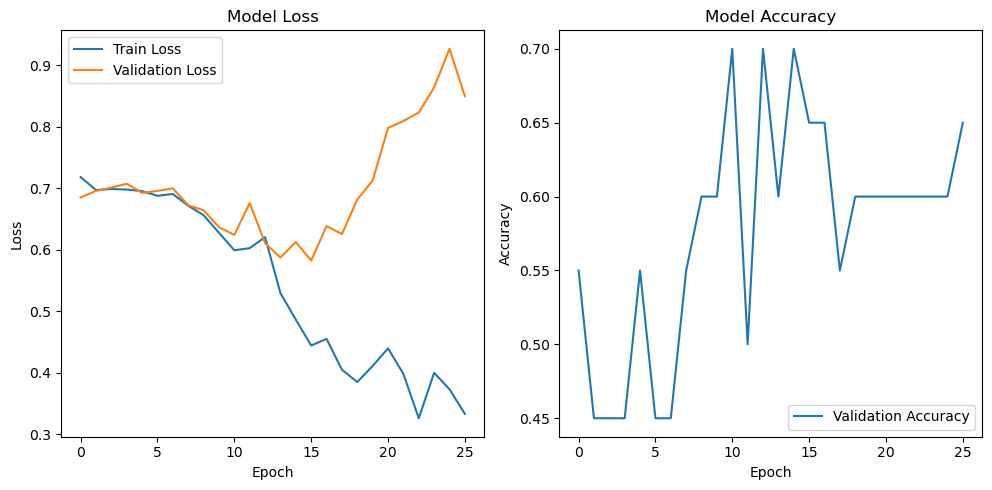

In [27]:
if __name__ == "__main__":
    main()